In [11]:
import pandas as pd
import re
import requests
from nltk import ngrams
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
llama_outputs = pd.read_json("https://raw.githubusercontent.com/Christianfoley/LLMLyricGen/main/data/taylor_swift_model_ouputs/llama-2-7b-chat-taylor-test-outputs.json")
llama_swift_outputs = pd.read_json("https://raw.githubusercontent.com/Christianfoley/LLMLyricGen/main/data/taylor_swift_model_ouputs/llama-2-7b-chat-ft_taylor_swift-taylor-test-outputs.json")
lyre_outputs = pd.read_json("https://raw.githubusercontent.com/Christianfoley/LLMLyricGen/main/data/taylor_swift_model_ouputs/lyre-chat_taylor_swift-checkpoint-10-taylor-test-outputs.json")

In [2]:
def clean_text(text):
    text = re.sub(r'\[.*?\]', '', text)
    return text.replace('\n',' ').replace('\r','').replace("\'", '').lower().replace(".", "").replace("!", "").replace(",","").replace("?","").strip()

In [3]:
master = "https://raw.githubusercontent.com/irenetrampoline/taylor-swift-lyrics/master/all_tswift_lyrics.txt"
req = requests.get(master)
all_text = req.text.replace('\n',' ').replace('\r','').replace("\'", '').lower().replace(".", "").replace("!", "").replace(",","").replace("?","").strip()

In [4]:
master = "https://gist.githubusercontent.com/deekayen/4148741/raw/98d35708fa344717d8eee15d11987de6c8e26d7d/1-1000.txt"
req = requests.get(master)
common_words = req.text.lower().split("\n")
common_words.append('')
common_words.append(' ')
common_words.extend(['didnt','wont','shouldnt','wouldnt','couldnt','cant','im','youre','hes','shes','thats','its','ive'])

In [6]:
# remove common pairings, aka "of the"
def get_ngrams(text, n):
    all_ngrams = set(ngrams(text, n))
    unique_ngrams = []
    for ngram in all_ngrams:
        num_common = 0
        for i in range(n):
            if ngram[i] not in common_words:
                break
            num_common += 1
        if num_common != n:
            unique_ngrams.append(ngram)
    return unique_ngrams

In [7]:
def get_similar_phrases(model_text, n):
    model_text = clean_text(model_text)
    all_text_list = all_text.split(' ')
    if ' ' in all_text_list:
        all_text_list.remove(' ') 
    if '' in all_text_list:
        all_text_list.remove('') 
    model_text_list = model_text.split(' ')
    if ' ' in model_text_list:
        model_text_list.remove(' ') 
    if '' in model_text_list:
        model_text_list.remove('') 
    all_ngrams = get_ngrams(all_text_list, n)
    model_ngrams = get_ngrams(model_text_list, n)
    return set(all_ngrams) & set(model_ngrams)

In [8]:
def generate_ngrams_plot(n):
    lyre_ngrams = lyre_outputs["model_output"].apply(lambda x: get_similar_phrases(x, n)).apply(len)
    llama_ngrams = llama_outputs["model_output"].apply(lambda x: get_similar_phrases(x, n)).apply(len)
    data_lyre = {
        'song': range(17),
        'num': lyre_ngrams,
        'model':'lyre'
    }
    data_llama = {
        'song': range(17),
        'num': llama_ngrams,
        'model':'llama'
    }
    df_lyre = pd.DataFrame(data_lyre)
    df_llama = pd.DataFrame(data_llama)
    df = pd.concat([df_lyre, df_llama], ignore_index=True)
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='song', y='num', hue='model', data=df)
    plt.xlabel('Song')
    plt.ylabel('Num' + str(n) + '-grams')
    plt.title('Generated' + str(n) + '-grams with existing Taylor lyrics')
    plt.legend(title='Variables')
    print("Lyre: ", sum(lyre_ngrams))
    print("Llama ", sum(llama_ngrams))

In [9]:
lyre_ngrams_counts = []
llama_swift_ngrams_counts = []
llama_ngrams_counts = []
for n in range(3, 7):
    lyre_ngrams = sum(lyre_outputs["model_output"].apply(lambda x: get_similar_phrases(x, n)).apply(len))
    llama_swift_ngrams = sum(llama_swift_outputs["model_output"].apply(lambda x: get_similar_phrases(x, n)).apply(len))
    llama_ngrams = sum(llama_outputs["model_output"].apply(lambda x: get_similar_phrases(x, n)).apply(len))
    lyre_ngrams_counts.append(lyre_ngrams)
    llama_swift_ngrams_counts.append(llama_swift_ngrams)
    llama_ngrams_counts.append(llama_ngrams)

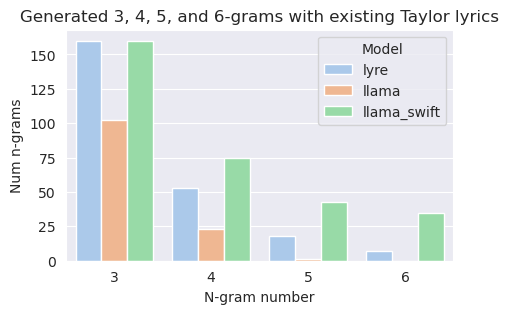

In [13]:
sns.set_style("darkgrid")

data_lyre = {
    'count': range(3, 7),
    'num':lyre_ngrams_counts,
    'model':'lyre'
}
data_llama = {
    'count': range(3, 7),
    'num': llama_ngrams_counts,
    'model':'llama'
}

data_llama_swift = {
    'count': range(3, 7),
    'num': llama_swift_ngrams_counts,
    'model':'llama_swift'
}

df_lyre = pd.DataFrame(data_lyre)
df_llama = pd.DataFrame(data_llama)
df_llama_swift = pd.DataFrame(data_llama_swift)
df = pd.concat([df_lyre, df_llama, df_llama_swift], ignore_index=True)

plt.figure(figsize=(5, 3))
sns.barplot(x='count', y='num', hue='model', data=df, palette='pastel')
plt.xlabel('N-gram number')
plt.ylabel('Num n-grams')
plt.title('Generated 3, 4, 5, and 6-grams with existing Taylor lyrics')
plt.legend(title='Model')